# Visually inspect the output of the dataset

(1, 1, 352, 512, 21) torch.Size([1, 1, 352, 512, 21])
z_idx 3
(1, 1, 352, 512, 21) torch.Size([1, 1, 352, 512, 21])
(1, 1, 176, 256, 10) torch.Size([1, 1, 176, 256, 10])
(1, 1, 88, 128, 5) torch.Size([1, 1, 88, 128, 5])
(1, 1, 44, 64, 2) torch.Size([1, 1, 44, 64, 2])
(1, 1, 22, 32, 1) torch.Size([1, 1, 22, 32, 1])


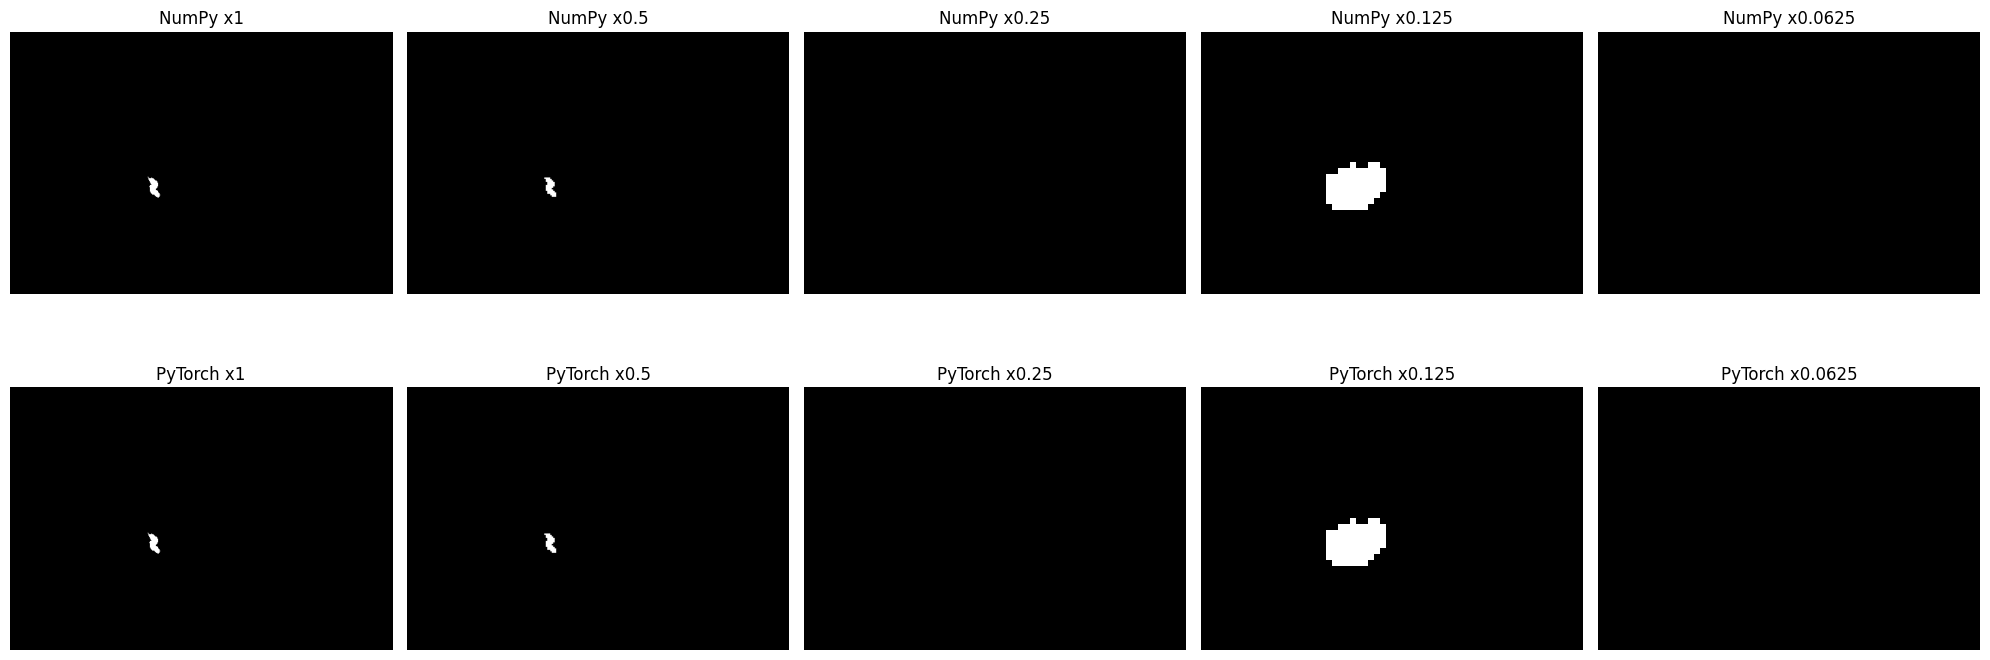

z_idx 4
(1, 1, 352, 512, 21) torch.Size([1, 1, 352, 512, 21])
(1, 1, 176, 256, 10) torch.Size([1, 1, 176, 256, 10])
(1, 1, 88, 128, 5) torch.Size([1, 1, 88, 128, 5])
(1, 1, 44, 64, 2) torch.Size([1, 1, 44, 64, 2])
(1, 1, 22, 32, 1) torch.Size([1, 1, 22, 32, 1])


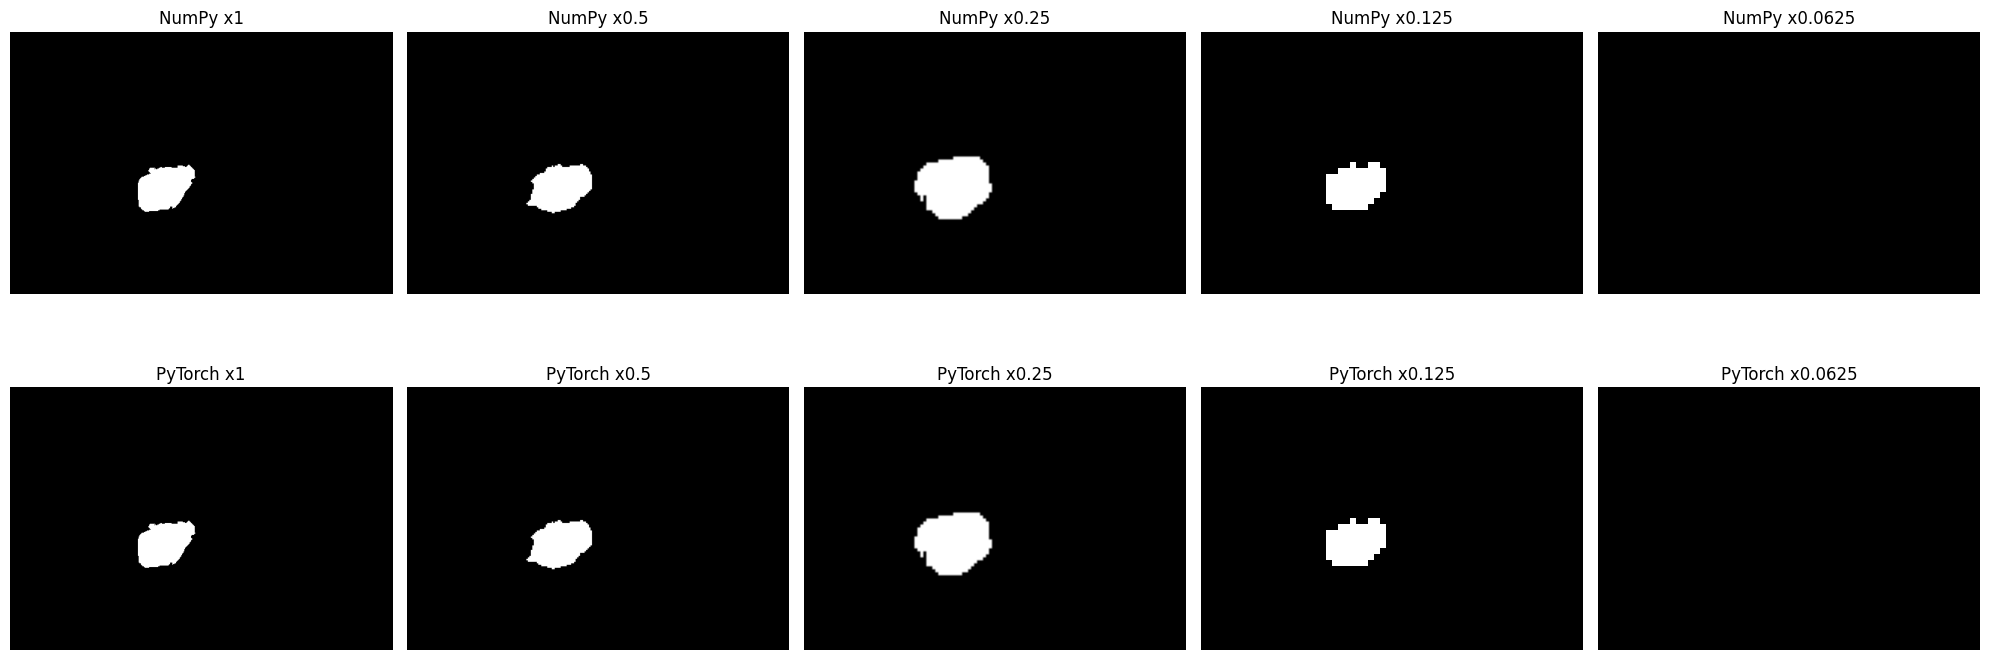

z_idx 5
(1, 1, 352, 512, 21) torch.Size([1, 1, 352, 512, 21])
(1, 1, 176, 256, 10) torch.Size([1, 1, 176, 256, 10])
(1, 1, 88, 128, 5) torch.Size([1, 1, 88, 128, 5])
(1, 1, 44, 64, 2) torch.Size([1, 1, 44, 64, 2])
(1, 1, 22, 32, 1) torch.Size([1, 1, 22, 32, 1])


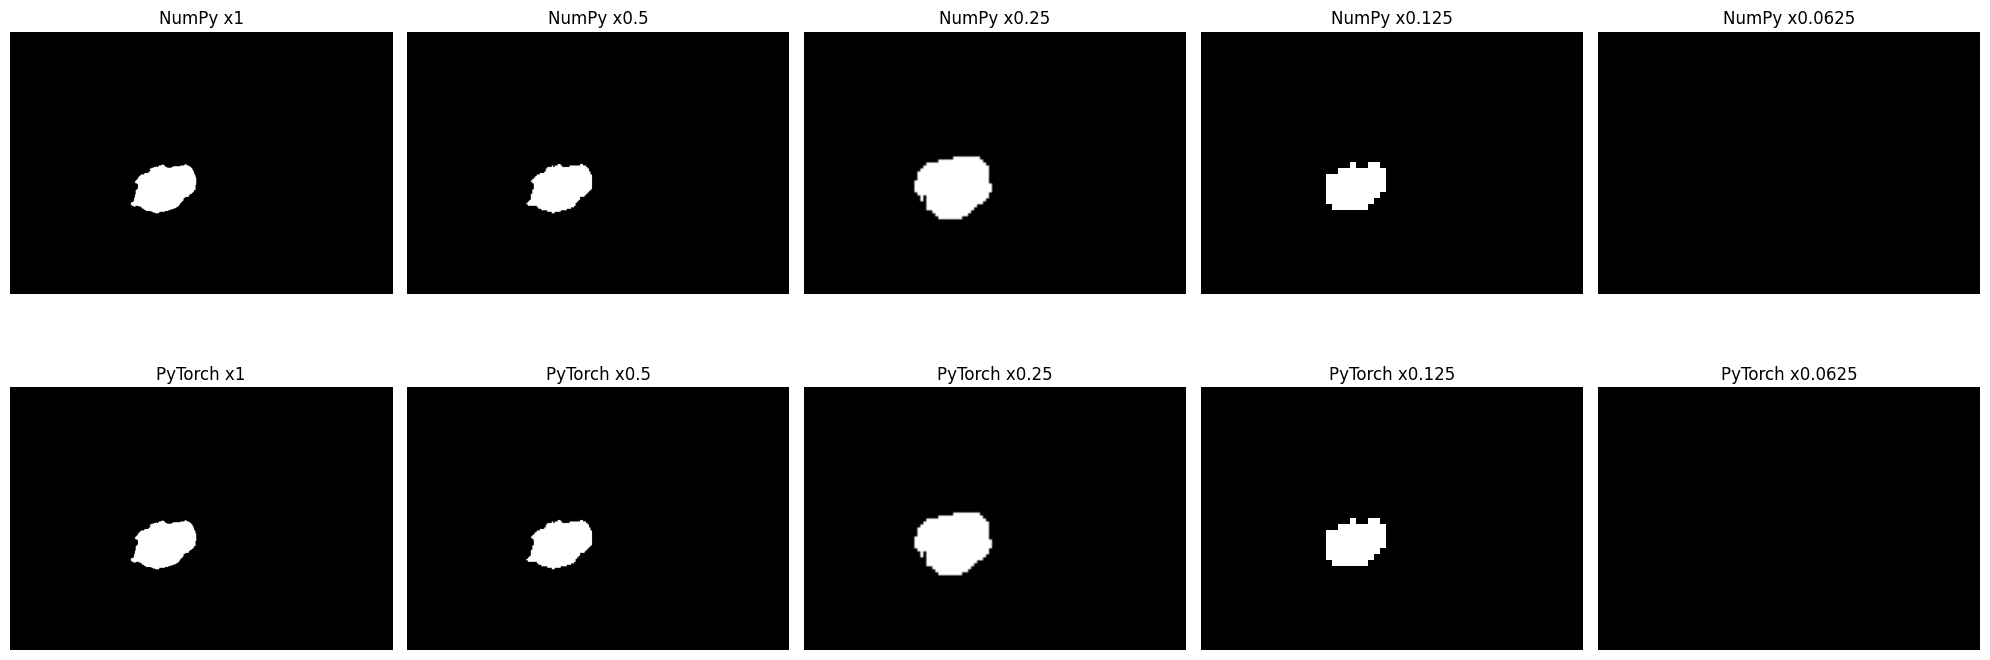

z_idx 6
(1, 1, 352, 512, 21) torch.Size([1, 1, 352, 512, 21])
(1, 1, 176, 256, 10) torch.Size([1, 1, 176, 256, 10])
(1, 1, 88, 128, 5) torch.Size([1, 1, 88, 128, 5])
(1, 1, 44, 64, 2) torch.Size([1, 1, 44, 64, 2])
(1, 1, 22, 32, 1) torch.Size([1, 1, 22, 32, 1])


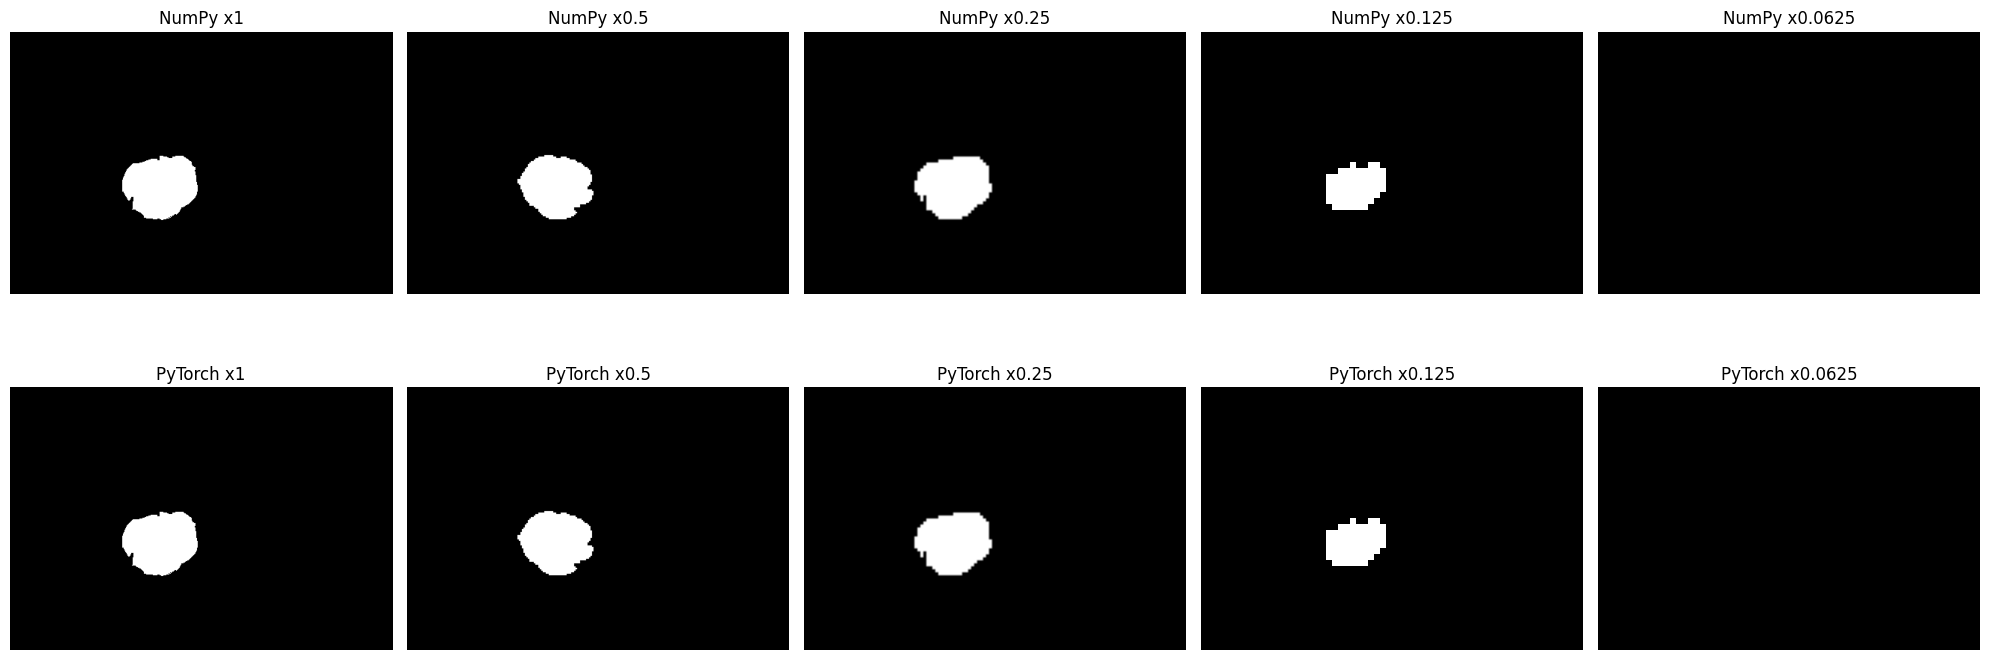

z_idx 7
(1, 1, 352, 512, 21) torch.Size([1, 1, 352, 512, 21])
(1, 1, 176, 256, 10) torch.Size([1, 1, 176, 256, 10])
(1, 1, 88, 128, 5) torch.Size([1, 1, 88, 128, 5])
(1, 1, 44, 64, 2) torch.Size([1, 1, 44, 64, 2])
(1, 1, 22, 32, 1) torch.Size([1, 1, 22, 32, 1])


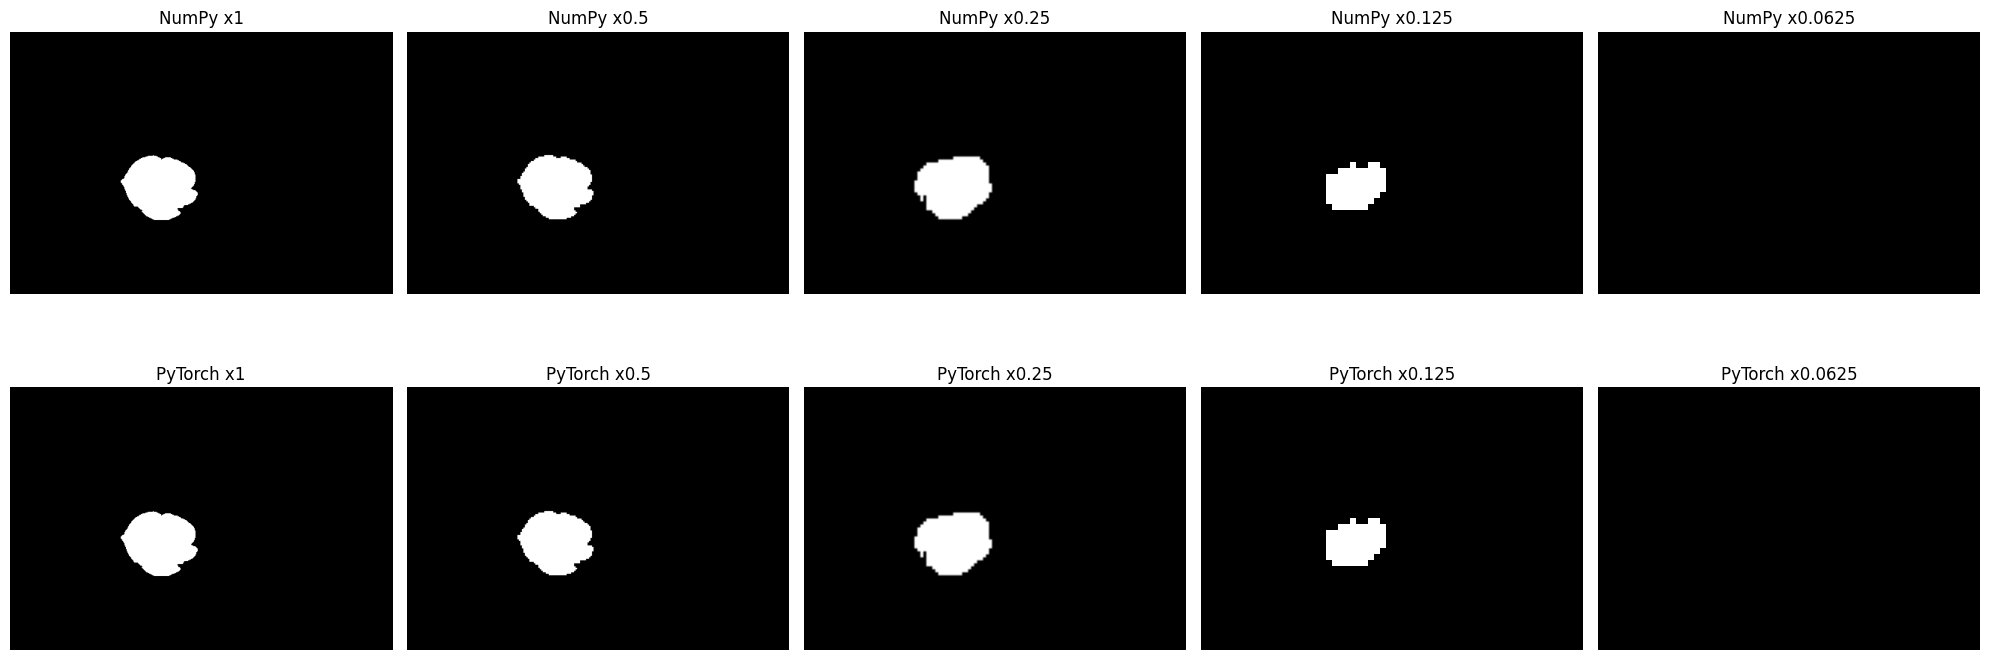

z_idx 8
(1, 1, 352, 512, 21) torch.Size([1, 1, 352, 512, 21])
(1, 1, 176, 256, 10) torch.Size([1, 1, 176, 256, 10])
(1, 1, 88, 128, 5) torch.Size([1, 1, 88, 128, 5])
(1, 1, 44, 64, 2) torch.Size([1, 1, 44, 64, 2])
(1, 1, 22, 32, 1) torch.Size([1, 1, 22, 32, 1])


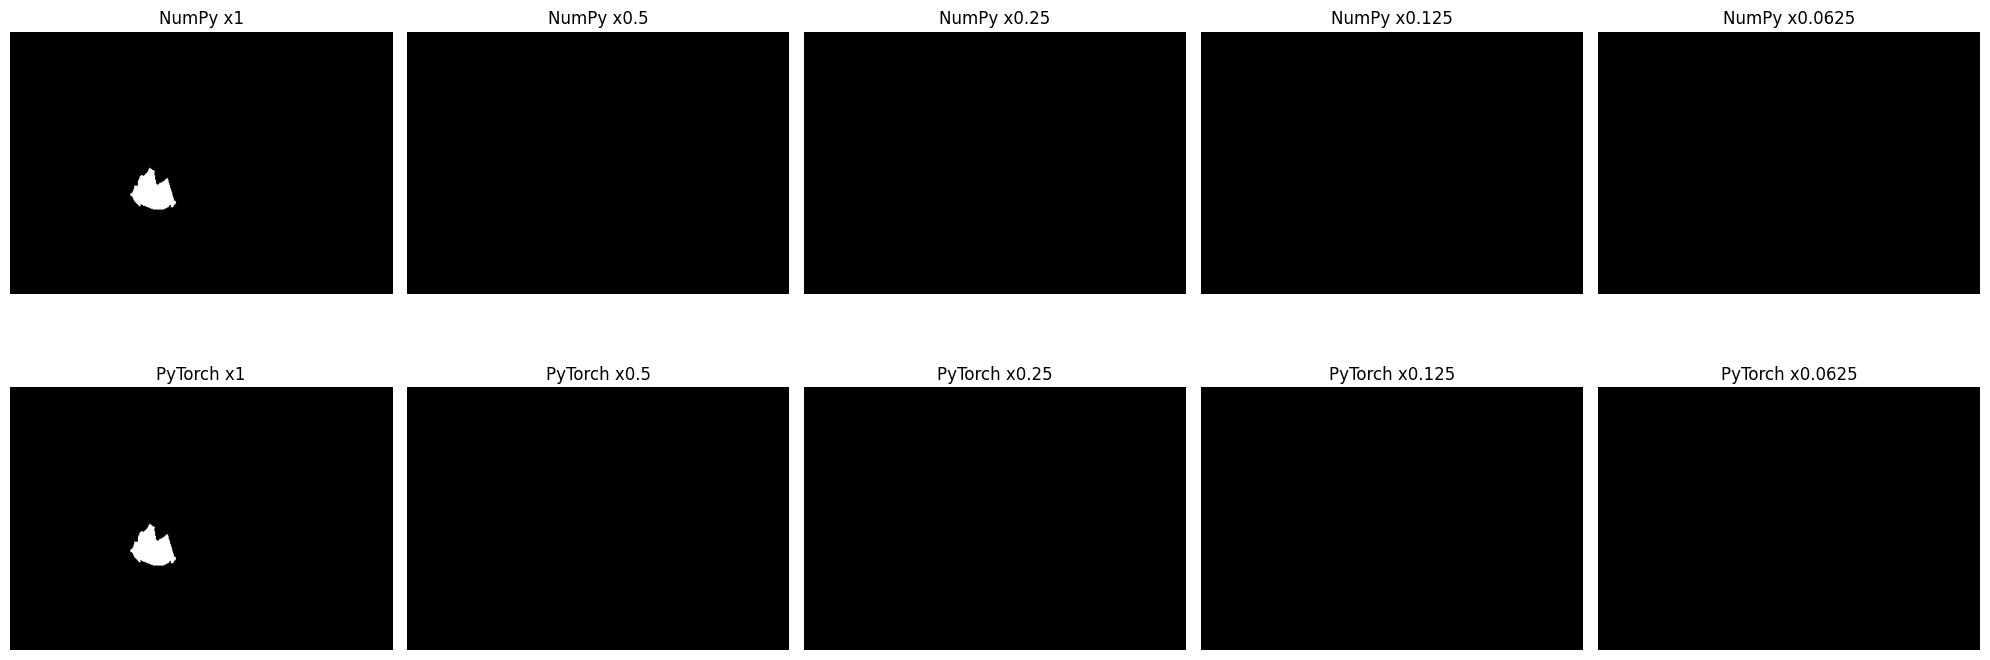

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from asparagus.modules.transforms.deep_supervision import downsample_label_torch
from pathlib import Path
from yucca.functional.transforms import downsample_label as downsample_label_numpy

i = 13

label_base = Path("/dtu/p1/asbmun/fomo/downstream/fomo-task2/labels")
subject_dirs = sorted(label_base.glob("sub_*"))
files = [label_base / f"sub_{p.name.split('_')[-1]}" / "ses_1" / "seg.nii.gz" for p in subject_dirs]
if not files:
    raise RuntimeError("No label files found")
factors = [1, 1 / 2, 1 / 4, 1 / 8, 1 / 16]

fp = files[i]
img = nib.load(fp)
label_np = img.get_fdata().astype(np.uint8)[None, None, ...]
label_torch = torch.from_numpy(label_np).type(torch.float32)

print(label_np.shape, label_torch.shape)

nonzero_slices = np.any(label_np, axis=(0, 1, 2, 3))  # → (Z,)
nz_idx = np.where(nonzero_slices)[0]
if nz_idx.size == 0:
    raise ValueError("No non-zero label voxels found")
z_idx = int(nz_idx[3])

for z_idx in nz_idx:
    print("z_idx", z_idx)
    numpy_list = downsample_label_numpy(label_np, factors)
    torch_list = downsample_label_torch(label_torch, factors)

    n = len(factors)
    plt.figure(figsize=(4 * n, 8))

    for j, (f, np_out, torch_out) in enumerate(zip(factors, numpy_list, torch_list)):
        print(np_out.shape, torch_out.shape)
        torch_np = torch_out.numpy()

        z_np = int(z_idx * np_out.shape[2] / label_np.shape[2])
        z_torch = int(z_idx * torch_np.shape[2] / label_np.shape[2])

        plt.subplot(2, n, j + 1)
        plt.imshow(np_out[0, 0, :, :, z_np], cmap="gray")
        plt.title(f"NumPy x{f}")
        plt.axis("off")

        plt.subplot(2, n, n + j + 1)
        plt.imshow(torch_np[0, 0, :, :, z_torch], cmap="gray")
        plt.title(f"PyTorch x{f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Calculate Dice between Numpy and Torch version

In [ ]:
label_base = Path("/dtu/p1/asbmun/fomo/downstream/fomo-task2/labels")
factors = [1, 1 / 2, 1 / 4, 1 / 8, 1 / 16]
strict = False  # True  → raise on ANY difference
compute_dice = True  # Set True if you want Dice statistics


def dice_score(a: np.ndarray, b: np.ndarray, label_ids=None):
    """
    Computes per-label Dice and returns their mean.
    `a` and `b` must have identical shape and dtype (ints).
    """
    if label_ids is None:
        label_ids = np.unique(np.concatenate([np.unique(a), np.unique(b)]))
    dices = []
    for lab in label_ids:
        inter = np.logical_and(a == lab, b == lab).sum()
        size_a = (a == lab).sum()
        size_b = (b == lab).sum()
        denom = size_a + size_b
        if denom == 0:  # label absent in both → ignore
            continue
        dices.append(2 * inter / denom)
    return float(np.mean(dices)) if dices else np.nan


results = []

subject_dirs = sorted(label_base.glob("sub_*"))
files = [label_base / f"sub_{p.name.split('_')[-1]}" / "ses_1" / "seg.nii.gz" for p in subject_dirs]
if not files:
    raise RuntimeError("No label files found under", label_base)

for fp in files:
    subj_id = fp.parent.parent.name  # "sub_XXX"
    vol = nib.load(fp).get_fdata().astype(np.uint8)[None, None, ...]  # (C=1, H, W, D)
    vol_t = torch.from_numpy(vol).float()

    np_downs = downsample_label_numpy(vol, factors)
    th_downs = downsample_label_torch(vol_t, factors)

    for f, np_out, th_out in zip(factors, np_downs, th_downs):
        th_np = th_out.numpy().astype(np_out.dtype, copy=False)

        diff = (np_out != th_np).astype(np.uint8)  # 1 where they differ, 0 otherwise
        n_diff = int(diff.sum())
        frac_diff = n_diff / diff.size
        mae = float(np.abs(np_out - th_np).mean())

        if strict and n_diff > 0:
            raise AssertionError(f"Mismatch detected for {subj_id} at factor {f}: {n_diff} voxels differ ({frac_diff:.6%})")

        row = dict(subject=subj_id, factor=f, n_diff=n_diff, frac_diff=frac_diff, mae=mae)
        if compute_dice:
            row["dice"] = dice_score(np_out, th_np)
        results.append(row)

# Summarise -------------------------------------------------------------------
df = pd.DataFrame(results)
print("\n=== Summary per down-sampling factor ===")
print(
    df.groupby("factor")
    .agg(
        subjects=("subject", "nunique"),
        mean_n_diff=("n_diff", "mean"),
        mean_frac_diff=("frac_diff", "mean"),
        mean_mae=("mae", "mean"),
        mean_dice=("dice", "mean"),
    )
    .sort_index()
)

overall_dice = df["dice"].mean()
print(f"\nOverall mean Dice across all factors and subjects: {overall_dice:.6f}")

print(
    "\nAll good! No differences found."
    if df["n_diff"].sum() == 0
    else "\nCompleted – review the table above for discrepancies."
)


=== Summary per down-sampling factor ===
        subjects  mean_n_diff  mean_frac_diff  mean_mae  mean_dice
factor                                                            
0.0625        23          0.0             0.0       0.0        1.0
0.1250        23          0.0             0.0       0.0        1.0
0.2500        23          0.0             0.0       0.0        1.0
0.5000        23          0.0             0.0       0.0        1.0
1.0000        23          0.0             0.0       0.0        1.0

Overall mean Dice across all factors and subjects: 1.000000

All good! No differences found.
